## Business Understanding

Describe the purpose of the data set you selected (i.e., why was this data collected in
the first place?). Describe how you would define and measure the outcomes from the
dataset. That is, why is this data important and how do you know if you have mined
useful knowledge from the dataset? How would you measure the effectiveness of a
good prediction algorithm? Be specific.

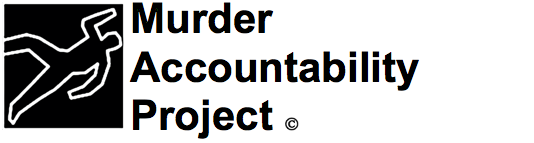

The Murder Accountability Project is the most complete database of homicides in the United States currently available. This dataset includes murders from the FBI's Supplementary Homicide Report from 1976 to the present and Freedom of Information Act data on more than 22,000 homicides that were not reported to the Justice Department. This dataset includes the age, race, sex, ethnicity of victims and perpetrators, in addition to the relationship between the victim and perpetrator and weapon used.

1980 to 2014

America does a poor job tracking and accounting for its unsolved homicides. Every year, at least 5,000 killers get away with murder. The rate at which police clear homicides through arrest has declines year over year. About a third of all murders go unsolved.

No one knows all the names of the murder victims because no law enforcement agency in America is assigned to monitor failed homicide investigations by local police departments. Even the official national statistics on murder are actually estimates and projections based upon incomplete reports by police departments that voluntarily choose (or refuse) to participate in federal crime reporting programs.

The Murder Accountability Project is a nonprofit group organized in 2015 and dedicated to educate Americans on the importance of accurately accounting for unsolved homicides within the United States. We seek to obtain information from federal, state and local governments about unsolved homicides and to publish this information. The Project’s Board of Directors is composed of retired law enforcement investigators, investigative journalists, criminologists and other experts on various aspects of homicide. 


Acknowledgements
The data was compiled and made available by the Murder Accountability Project, founded by Thomas Hargrove.
https://www.murderdata.org/

* If categorical (classification) - accuracy, precision, recall, f1 score, ROC curve
* If continuous (regression) - root mean sq error, mean absolute sq error, mean absolute percentage error, r-squared (not really good for accuracy)

In [ ]:
# import libraries used
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
%matplotlib inline 
#plt.figure(figsize=(22,10),facecolor='#ffffff')

import plotly.graph_objects as go
import plotly.express as px
import sweetviz as sv
import autoviz
import xgboost
import seaborn as sns

# set color scheme and style for seaborn
sns.set(color_codes=True)
sns.set_style('whitegrid')

In [ ]:
from pandas_profiling import ProfileReport
from mpl_toolkits.mplot3d import Axes3D
from autoviz.AutoViz_Class import AutoViz_Class
AV = AutoViz_Class()
from funpymodeling.exploratory import corr_pair
from autoplotter import run_app 
from ExploriPy import EDA

## Data Meaning Type

Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file.



Record ID - unique identifier 1-638,454
continuous
id
high correlation

Agency Code - unique id that represents agency name, angency type, city, and state
categorical
12,003 distinct agency codes
high cardinality

Agency Name - name of the agency that investigated the case
categorical
9,216 distinct agencies
high cardinality

Agency Type - the type of agency (municipal, county, state, sheriff, special, regional, tribal)
categorical
7 distinct types

City - city name where case was investigated
categorical
1782 distinct cities
high cardinality

State - state name where case was investigated
Categorical
all 50 states and DC
high cardinality

Year - year when the case was initially investigated
continuous
1980-2014

Month - month when the case was initially investigated
Categorical
all 12 months


Incident - incidents investigated
continuous
0-999

# validate if there are really 999 incidents
# convert 0's to mean?

Crime Type - type of crime committed
Categorical
Murder or Manslaughter 629,338
Manslaughter by Negligence 9,116

Crime Solved - was the crime solved yes or no
Boolean
Yes 448,172
No 190,282
changed yes=1 and no=0

Victim Sex - victims sex
Categorical
male 494,125
female 143,345
unknown 984

Victim Age - victims age
Categorical
0-998
8,444 are zero's
removed ages > 98
converted 0's to median

Victim Race - victims race
Categorical
White	317422
Black	299899
Asian/Pacific Islander	 9890
Unknown	 6676
Native American/Alaska Native	 4567

Victim Ethnicity - victims ethnicity
Categorical
Unknown	368303
Not Hispanic	197499
Hispanic	 72652

Perpetrator Sex - perpetrators sex
Categorical
Male	399541
Unknown	190365
Female	 48548

Perpetrator Age - perpetrators age
Categorical
0-99
high cardinality
converted " " to 0
removed ages > 98
converted 0's to median

Perpetrator Race - perpetrators race
Categorical
White	218243
Black	214516
Unknown	196047
Asian/Pacific Islander	 6046
Native American/Alaska Native	 3602

Perpetrator Ethnicity - perpetrators ethnicity
Categorical
Unknown	446410
Not Hispanic	145172
Hispanic	 46872

Relationship - relationship to the victim
Categorical
28 distinct relationships

Weapon - weapon used in the murder
Categorical
16 distinct weapons

Victim Count - number of victims murdered
continuous
0-10

Perpetrator Count - number of perpetrators involved in the murder
continuous
0-10

Record Source - the source of the murder data
Categorical
FBI	(Federal Bureau of Investigation) 616647
FOIA (Freedom of Information Act)	 21807

In [ ]:
# read the homicide data file that was downloaded from Kaggle
# https://www.kaggle.com/murderaccountability/homicide-reports
homicide_df = pd.read_csv('../Data/database.csv', low_memory=False)

# Return the first five observation from the data set
homicide_df.head()

In [ ]:
# concise summary of the dataframe
homicide_df.loc[:, homicide_df.dtypes == 'object'] =\
    homicide_df.select_dtypes(['object'])\
    .apply(lambda x: x.astype('category'))
homicide_df.info()

In [ ]:
homicide_df['Crime Solved']=homicide_df['Crime Solved'].replace(to_replace='No',value=0)
homicide_df['Crime Solved']=homicide_df['Crime Solved'].replace(to_replace='Yes',value=1)

homicide_df['Perpetrator Age']=homicide_df['Perpetrator Age'].replace(to_replace=" ",value=0)
homicide_df['Perpetrator Age'] = homicide_df['Perpetrator Age'].astype(int)
#homicide_df['Perpetrator Age']=pd.to_numeric(homicide_df['Perpetrator Age'])
index=homicide_df[homicide_df['Perpetrator Age'] > 98].index
homicide_df.drop(index, inplace=True)
homicide_df['Perpetrator Age']=homicide_df['Perpetrator Age'].replace(to_replace=0,value=homicide_df['Perpetrator Age'].median())

homicide_df['Victim Age']=homicide_df['Victim Age'].replace(to_replace=998,value=homicide_df['Victim Age'].median())

The dataset consists of 24 variables and 638,454 observations
17 categorical
6 continuous
1 boolean 


In [ ]:
# Displays unique values and their counts
homicide_df['Agency Code'].value_counts()

In [ ]:
homicide_df['Agency Name'].value_counts()

In [ ]:
homicide_df['Agency Type'].value_counts()

In [ ]:
homicide_df['City'].value_counts()

In [ ]:
homicide_df['State'].value_counts()

In [ ]:
homicide_df['Crime Type'].value_counts()

In [ ]:
homicide_df['Crime Solved'].value_counts()

In [ ]:
homicide_df['Victim Sex'].value_counts()

In [ ]:
homicide_df['Victim Age'].value_counts()

In [ ]:
homicide_df['Victim Race'].value_counts()

In [ ]:
homicide_df['Victim Ethnicity'].value_counts()

In [ ]:
homicide_df['Perpetrator Sex'].value_counts()

In [ ]:
homicide_df['Perpetrator Age'].value_counts()

In [ ]:
homicide_df['Perpetrator Race'].value_counts()

In [ ]:
homicide_df['Perpetrator Ethnicity'].value_counts()

In [ ]:
homicide_df['Relationship'].value_counts()

In [ ]:
homicide_df['Weapon'].value_counts()

In [ ]:
homicide_df['Record Source'].value_counts()

In [ ]:
homicide_df['Victim Count'].value_counts()

In [ ]:
homicide_df['Perpetrator Count'].value_counts()

## Data Quality

 Explain any missing values, duplicate data, and outliers. Are those mistakes? How do you deal with these problems? Be specific.


In [ ]:
# check for null values
homicide_df.isnull().sum()

In [ ]:
# Rows containing duplicate data
duplicate_rows_df = homicide_df[homicide_df.duplicated()]
print("Duplicate rows: ", duplicate_rows_df)

In [ ]:
homicide_df.nunique()

In [ ]:
Q1 = homicide_df.quantile(0.25)
Q3 = homicide_df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

In [ ]:
fig, axes = plt.subplots(nrows=5,ncols=1)
fig.set_size_inches(10, 30)
sns.boxplot(data=homicide_df,x="Incident",orient="h",ax=axes[0])
sns.boxplot(data=homicide_df,x="Victim Age",orient="h",ax=axes[1])
sns.boxplot(data=homicide_df,x="Victim Count",orient="h",ax=axes[2])
sns.boxplot(data=homicide_df,x="Perpetrator Count",orient="h",ax=axes[3])
sns.boxplot(data=homicide_df,x="Perpetrator Age",orient="h",ax=axes[4])

In [ ]:
fig, axes = plt.subplots(nrows=5,ncols=1)
fig.set_size_inches(10, 30)
sns.distplot(homicide_df['Incident'],ax=axes[0], bins=15)
sns.distplot(homicide_df['Victim Age'],ax=axes[1], bins=10)
sns.distplot(homicide_df['Victim Count'],ax=axes[2])
sns.distplot(homicide_df['Perpetrator Count'],ax=axes[3])
sns.distplot(homicide_df['Perpetrator Age'],ax=axes[4], bins=10)

In [ ]:
sns.set()
cols = ['Perpetrator Age', 'Perpetrator Count', 'Victim Age', 'Victim Count', 'Year']

# Create a pairplot for the selected columns 
sns.pairplot(homicide_df[cols], height = 2.5)

# show the plot
plt.show();

In [ ]:
from scipy import stats
z=np.abs(stats.zscore(homicide_df['Incident']))
threshold=3
print(z)
print(np.where(z>3))

In [ ]:
print(np.where(z<3))

## Simple Statistics

Give simple, appropriate statistics (range, mode, mean, median, variance, counts, etc.) for the most important attributes and describe what they mean or if you found something interesting. Note: You can also use data from other sources for comparison. Explain the significance of the statistics run and why they are meaningful.


In [ ]:
# count, mean, standard deviation, minimum and maximum values and the quantities of the data
homicide_df.describe().T

## Visualize Attributes

Visualize the most important attributes appropriately (at least 5 attributes). Important: Provide an interpretation for each chart. Explain for each attribute why the chosen visualization is appropriate.

Visualize attributes is just individual attributes

In [ ]:
states_vis=sns.countplot(data=homicide_df, x='State', order=homicide_df['State'].value_counts().index);

for item in states_vis.get_xticklabels():
    item.set_rotation(90)

In [ ]:
# Tops states,cities and solve rate with the highest homicide numbers
fig, axes = plt.subplots(nrows=3,ncols=1)
fig.set_size_inches(20, 45)

homicide_df.groupby("State").count()['Record ID'].sort_values(ascending=False).head(10).plot.bar(ax=axes[0])
homicide_df.groupby(["State","City"])['Record ID'].agg('count').sort_values(ascending=False).groupby("State").head(3).iloc[:15].plot.bar(ax=axes[1])
homicide_df.groupby("Crime Solved").count()['Record ID'].sort_values(ascending=False).plot.bar(ax=axes[2])

In [ ]:
# Tops agency names & types and solve rate with the highest homicide numbers
fig, axes = plt.subplots(nrows=2,ncols=1)
fig.set_size_inches(20, 45)
homicide_df.groupby("Agency Code").count()['Record ID'].sort_values(ascending=False).head(10).plot.bar(ax=axes[0])
homicide_df.groupby("Agency Type").count()['Record ID'].sort_values(ascending=False).plot.bar(ax=axes[1])

In [ ]:
# Victim demographic variables
fig, axes = plt.subplots(nrows=3,ncols=1)
fig.set_size_inches(15, 25)
                         
homicide_df.groupby(['Victim Sex','Crime Solved'])['Record ID'].count().sort_values(ascending=False).unstack().plot.bar(ax=axes[0])
homicide_df.groupby(['Victim Race','Crime Solved'])['Record ID'].count().sort_values(ascending=False).unstack().plot.bar(ax=axes[1])
homicide_df.groupby(['Victim Ethnicity','Crime Solved'])['Record ID'].count().sort_values(ascending=False).unstack().plot.bar(ax=axes[2])


In [ ]:
# Perpetrator demographic variables
fig, axes = plt.subplots(nrows=3,ncols=1)
fig.set_size_inches(15, 25)
                         
homicide_df.groupby(['Perpetrator Sex','Crime Solved'])['Record ID'].count().sort_values(ascending=False).unstack().plot.bar(ax=axes[0])
homicide_df.groupby(['Perpetrator Race','Crime Solved'])['Record ID'].count().sort_values(ascending=False).unstack().plot.bar(ax=axes[1])
homicide_df.groupby(['Perpetrator Ethnicity','Crime Solved'])['Record ID'].count().sort_values(ascending=False).unstack().plot.bar(ax=axes[2])

In [ ]:
# Homicides by year and month
fig, axes = plt.subplots(nrows=2,ncols=1)
fig.set_size_inches(15, 15)

homicide_df.groupby('Year')['Record ID'].count().sort_index(ascending = True).plot.line(ax=axes[0])
homicide_df.groupby(['Year','Month'])['Record ID'].count().sort_index(ascending = True).unstack().plot.line(ax=axes[1])

In [ ]:
sns.heatmap(homicide_df[['Year','Month']])

## Explore Joint Attributes

Explore relationships between attributes: Look at the attributes via scatter plots, correlation, cross-tabulation, group-wise averages, etc. as appropriate. Explain any interesting relationships.

Explore joint attributes is the comparing of multiple attributes (pairwise and correlation are good options)

In [ ]:
fig, axes = plt.subplots(nrows=2,ncols=1)
fig.set_size_inches(50, 30)
sns.boxplot(x="Perpetrator Sex", y="Perpetrator Age", data=homicide_df, hue="Weapon", ax=axes[0])
sns.boxplot(x="Perpetrator Race", y="Perpetrator Ethnicity", data=homicide_df, hue="Weapon", ax=axes[1])

In [ ]:
fig, axes = plt.subplots(nrows=2,ncols=1)
fig.set_size_inches(50, 30)
sns.boxplot(x="Crime Solved", y="Victim Age", data=homicide_df, hue="Relationship", ax=axes[0])
sns.boxplot(x="Victim Sex", y="Victim Age", data=homicide_df, hue="Relationship", ax=axes[1])

In [ ]:
plt.figure(figsize=(20,10))
sns.set()
cmap = sns.cubehelix_palette(start=0, light=1, as_cmap=True)
sns.heatmap(pd.crosstab(homicide_df['Relationship'],homicide_df['Weapon']), annot=True, fmt="d", linewidths=.5,cmap='Blues')
plt.title('Relationship and Weapon\n',fontsize=26)

In [ ]:
plt.figure(figsize=(20,10))
sns.set()
cmap = sns.cubehelix_palette(start=0, light=1, as_cmap=True)
sns.heatmap(pd.crosstab(homicide_df['Perpetrator Race'],homicide_df['Weapon']), annot=True, fmt="d", linewidths=.5,cmap='Blues')
plt.title('Perpetrator Race and Weapon\n',fontsize=26)

In [ ]:
plt.figure(figsize=(20,10))
sns.set()
cmap = sns.cubehelix_palette(start=0, light=1, as_cmap=True)
sns.heatmap(pd.crosstab(homicide_df['Perpetrator Ethnicity'],homicide_df['Weapon']), annot=True, fmt="d", linewidths=.5,cmap='Blues')
plt.title('Perpetrator Ethnicity and Weapon\n',fontsize=26)

In [ ]:
homicide_df.groupby(['Weapon','State','Year','Crime Solved'])['Crime Solved'].agg(['sum'])

In [ ]:
px.scatter(homicide_df, x="State",y='Weapon', color="Crime Solved",
                 hover_name="Weapon",template="plotly_dark",
                 animation_frame='Year',animation_group='State')

## Explore Attributes and Class

Identify and explain interesting relationships between features and the class you are trying to predict (i.e., relationships with variables and the target classification).

Prediction can include 1 or more attributes (i.e. Perpetrator age and race to predict the profile of a murder based on other attributes

In [ ]:
# check correlation
plt.figure(figsize=(8,4))
sns.heatmap(homicide_df.corr())

In [ ]:
corr_pair(homicide_df)

## New Features

Are there other features that could be added to the data or created from existing features? Which ones?

New features - can we do something to clean up city, state, and agency? (qcut in pandas)

In [ ]:
homicide.loc[(homicide['Relationship'] == 'Wife') | (homicide['Relationship'] == 'Ex-Wife') |
             (homicide['Relationship'] == 'Girlfriend') |
             (homicide['Relationship'] == 'Common-Law Wife'), 'Rel_Category'] = 'Partner-F'

homicide.loc[(homicide['Relationship'] == 'Husband') | (homicide['Relationship'] == 'Ex-Husband') |
             (homicide['Relationship'] == 'Boyfriend') | 
             (homicide['Relationship'] == 'Common-Law Husband'), 'Rel_Category'] = 'Partner-M'

homicide.loc[(homicide['Relationship'] == 'Father') | (homicide['Relationship'] == 'In-Law') |
             (homicide['Relationship'] == 'Mother') | (homicide['Relationship'] == 'Stepfather') |
             (homicide['Relationship'] == 'Stepmother'), 'Rel_Category'] = 'Parent'

homicide.loc[(homicide['Relationship'] == 'Daughter') | (homicide['Relationship'] == 'Son') |
             (homicide['Relationship'] == 'Stepdaughter') | 
             (homicide['Relationship'] == 'Stepson'), 'Rel_Category'] = 'Children'

homicide.loc[(homicide['Relationship'] == 'Brother') | (homicide['Relationship'] == 'Sister'),
             'Rel_Category'] = 'Sibling'

homicide.loc[(homicide['Relationship'] == 'Employee') | (homicide['Relationship'] == 'Employer') ,
             'Rel_Category'] = 'Work'

homicide.loc[(homicide['Relationship'] == 'Boyfriend/Girlfriend') & (homicide['Victim_Sex'] == 'Female'),
             'Rel_Category'] = 'Partner-F'

homicide.loc[(homicide['Relationship'] == 'Boyfriend/Girlfriend') & ((homicide['Victim_Sex'] == 'Male') |
            (homicide['Victim_Sex'] == 'Unknown')) , 'Rel_Category'] = 'Partner-M'

## Exceptional

Include PCA and fit a model for exceptional points

Initial view of the dataset shows that headers are descriptive enough and won't require any changes. However, we need to look at the equivalent of a N/A in the Perpetrator and Victim Age columns. The N/A equivalent is 0.

In [ ]:
profile = ProfileReport(homicide_df, title="Pandas Profiling Report")
profile.to_file("pandas_report.html")

In [ ]:
#https://www.analyticsvidhya.com/blog/2020/08/exploratory-data-analysiseda-from-scratch-in-python/
#https://analyticsindiamag.com/beginners-guide-to-pyjanitor-a-python-tool-for-data-cleaning/
# for normalizing, scaling, and encoding categorical values

In [ ]:
# sample EDA
#https://github.com/Dongee-W/EDA-python-spark/blob/master/seaborn.ipynb
#https://www.geeksforgeeks.org/exploratory-data-analysis-in-python/